# $Completing \ Incomplete \ Curves$
In this section, we delineate our mathematical methodology for detecting occlusions from Scalable Vector Graphics (SVG) file Bezier curves. Our approach leverages advanced geometric analysis and computational techniques to achieve precise occlusion detection and infilling.
#### Methodology:
We have adhered to traditional geometry and computer graphics algorithms to fill in occluded portions with a **single cubic bezier curve**.  
Our approach has been to first obtain an SVG by Bezier interpolation from CSV point mappings, and then building the infilling algorithm on the basis of corner points.  

Our approach can be divided into the following stages:  

1. **Mediating Close-by Point Clusters**: The bezier curves end points provided in the SVG file are not exactly flush with each other. Thus we have implemented the DBSCAN algorithm to mediate any set of two or more points, with a tolerance value of 0.5 absolute distance.  
*Complexity*: **O(nlogn)**

2. **Planarize the Bezier Plot**: This step simply takes care of removing all the overlapping bezier curves within the SVG file. We found it very crucial not to rely on overlapping curves within a SVG file to detect occlusion, since hand drawn doodles may not always produce overlappings unlike the two given testcases.  
*Complexity*: **O(n)**

3. **Extract Corner Points**: We have used extracted corner points by analyzing discontinuities occuring along the tangents occuring at that point from all the bezier curves it is subjected with. This approach is more robust because it does not rely on sharp-turning overlaps to find and process corners.  
*Complexity*: **O(n*n)**

4. **Point Pairing Logic**: We have used an extensive analytical method that pairs up appropriate corner points with each other, based on their tangent angles, proximities and the centre of curvature for their respective bezier osculating circles.  
*Complexity*: **O(n*n)**

In [1]:
import numpy as np
from svgpathtools import svg2paths
from scipy.special import binom
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import math
from math import atan2, degrees, sqrt
from itertools import combinations
file_path = 'data/problems/occlusion2.svg'

### Utility Functions

These are functions that we use for extraction, analysis, plotting and generating of bezier curves.   
They are largely reliant on **De Casteljau's algorithm** for interpolating cubic bezier curves.

Following equations have been manifested in code:

$
B_{i}^{0} = P_i
$

$
B_{i}^{k} = (1-t)B_{i}^{k-1} + tB_{i+1}^{k-1}
$

Where:  
- *t* is a parameter in the range [0, 1]
- $B_{i}^{k}$ is the control point for a k-degree curve.

We have also extracted the osculating curve centres for the bezier curves for an in-depth analysis.  
**Curvature**:
$\kappa(t) = \frac{|\mathbf{r}'(t) \times \mathbf{r}''(t)|}{|\mathbf{r}'(t)|^3}$

**Centre**:
$\mathbf{C}(t) = \mathbf{r}(t) + \frac{1}{\kappa(t)} \cdot \frac{\mathbf{T}'(t)}{|\mathbf{T}'(t)|}$

The docstrings and comments will provide more insight to our code:



In [2]:
def bernstein_poly(i, n, t):
    """
    Calculate the Bernstein polynomial.

    Args:
        i (int): The index of the polynomial.
        n (int): The degree of the polynomial.
        t (numpy.ndarray): The parameter values.

    Returns:
        numpy.ndarray: The evaluated Bernstein polynomial.
    """
    return binom(n, i) * (t**(n-i)) * ((1 - t)**i)



def bezier_curve(points, n_points=100):
    """
    Compute the Bézier curve from a set of control points.

    Args:
        points (numpy.ndarray): Control points for the Bézier curve.
        n_points (int): Number of points to sample along the curve.

    Returns:
        numpy.ndarray: The points of the Bézier curve.
    """
    n = len(points) - 1
    t = np.linspace(0, 1, n_points)
    curve = np.zeros((n_points, 2))
    for i in range(n + 1):
        curve += np.outer(bernstein_poly(i, n, t), points[i])
    return curve



def bezier_derivatives(points, n_points=100):
    """
    Compute the first and second derivatives of the Bézier curve.

    Args:
        points (numpy.ndarray): Control points for the Bézier curve.
        n_points (int): Number of points to sample along the curve.

    Returns:
        tuple: A tuple containing two numpy arrays:
            - d_curve: The first derivative of the Bézier curve.
            - d2_curve: The second derivative of the Bézier curve.
    """
    n = len(points) - 1
    t = np.linspace(0, 1, n_points)
    d_curve = np.zeros((n_points, 2))
    d2_curve = np.zeros((n_points, 2))
    
    for i in range(n):
        d_curve += np.outer(bernstein_poly(i, n-1, t), n * (points[i+1] - points[i]))
    
    for i in range(n-1):
        d2_curve += np.outer(bernstein_poly(i, n-2, t), n * (n-1) * (points[i+2] - 2*points[i+1] + points[i]))
    
    return d_curve, d2_curve



def extract_bezier_curves(svg_file):
    """
    Extract cubic and quadratic Bezier curves from an SVG file.

    Args:
        svg_file (str): Path to the SVG file.

    Returns:
        tuple: A tuple containing two numpy arrays:
            - cubic_bezier_points: Array of cubic Bezier curves, each represented by control points.
            - quadratic_bezier_points: Array of quadratic Bezier curves, each represented by control points.
    """
    paths, _ = svg2paths(svg_file)
    
    cubic_bezier_points = []
    quadratic_bezier_points = []

    for path in paths:
        for segment in path:
            if segment.__class__.__name__ == 'CubicBezier':
                cubic_bezier_points.append([
                    (segment.start.real, segment.start.imag),
                    (segment.control1.real, segment.control1.imag),
                    (segment.control2.real, segment.control2.imag),
                    (segment.end.real, segment.end.imag)
                ])
            elif segment.__class__.__name__ == 'QuadraticBezier':
                quadratic_bezier_points.append([
                    (segment.start.real, segment.start.imag),
                    (segment.control.real, segment.control.imag),
                    (segment.end.real, segment.end.imag)
                ])
    
    cubic_bezier_points = np.array(cubic_bezier_points)
    quadratic_bezier_points = np.array(quadratic_bezier_points)
    return cubic_bezier_points, quadratic_bezier_points



def osculating_circle_center(points, threshold, n_points=100):
    """
    Compute the centers of osculating circles for a Bézier curve and filter by threshold.

    Args:
        points (numpy.ndarray): Control points for the Bézier curve.
        threshold (float): Distance threshold for considering osculating circle centers.
        n_points (int): Number of points to sample along the curve.

    Returns:
        numpy.ndarray: The centers of osculating circles within the threshold distance.
    """
    curve = bezier_curve(points, n_points)
    d_curve, d2_curve = bezier_derivatives(points, n_points)
    
    curvature = (d_curve[:, 0] * d2_curve[:, 1] - d_curve[:, 1] * d2_curve[:, 0]) / (d_curve[:, 0]**2 + d_curve[:, 1]**2)**1.5
    radius_of_curvature = 1 / np.abs(curvature)
    
    normal = np.zeros_like(d_curve)
    normal[:, 0] = -d_curve[:, 1]
    normal[:, 1] = d_curve[:, 0]
    normal_direction = np.sign(curvature)
    normal *= normal_direction[:, np.newaxis]
    normal /= np.linalg.norm(normal, axis=1, keepdims=True)
    
    centers = curve + normal * radius_of_curvature[:, np.newaxis]
    
    # Filter centers based on threshold distance from the curve
    distances = np.linalg.norm(centers - curve, axis=1)
    valid_centers = centers[distances < threshold]
    
    return valid_centers




def calculate_curvature(points, n_points=100):
    """
    Calculate the curvature of a Bézier curve.

    Args:
        points (numpy.ndarray): Control points for the Bézier curve.
        n_points (int): Number of points to sample along the curve.

    Returns:
        numpy.ndarray: The curvature values of the Bézier curve.
    """
    d_curve, d2_curve = bezier_derivatives(points, n_points)
    
    curvature = (d_curve[:, 0] * d2_curve[:, 1] - d_curve[:, 1] * d2_curve[:, 0]) / (d_curve[:, 0]**2 + d_curve[:, 1]**2)**1.5
    return curvature



def plot_bezier_curves(cubic_points, quadratic_points, threshold=1.0, show_centres = False, size = 10):
    plt.figure(figsize=(size, size))
    
    for points in cubic_points:
        curve = bezier_curve(points)
        centers = osculating_circle_center(points, threshold)
        color = np.random.rand(3,)  # Random color for each curve
        plt.plot(curve[:, 0], curve[:, 1], label='Cubic Bezier', color=color)
        #plt.plot(points[:, 0], points[:, 1], 'ro--')  # Control points
        if show_centres == True:
            plt.plot(centers[:, 0], centers[:, 1], 'x', label='Osculating Circle Centers', color=color)  # Osculating circle centers
    
    for points in quadratic_points:
        curve = bezier_curve(points)
        centers = osculating_circle_center(points, threshold)
        color = np.random.rand(3,)  # Random color for each curve
        plt.plot(curve[:, 0], curve[:, 1], label='Quadratic Bezier', color=color)
        plt.plot(points[:, 0], points[:, 1], 'bo--')  # Control points
        if show_centres == True:
            plt.plot(centers[:, 0], centers[:, 1], 'x', label='Osculating Circle Centers', color=color)  # Osculating circle centers
    
    #plt.legend()
    if(show_centres == True):
        plt.title('Bezier Curves with Osculating Circle Centres')
    else:
        plt.title('Bezier Curves')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid()
    plt.show()

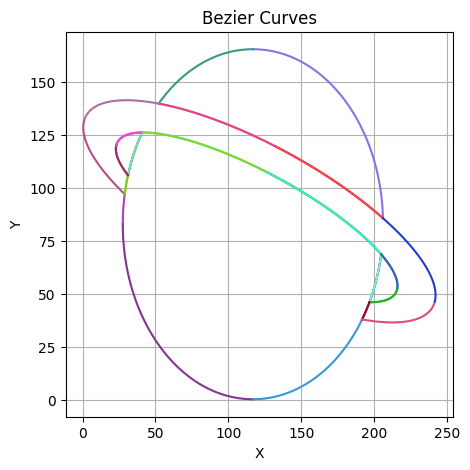

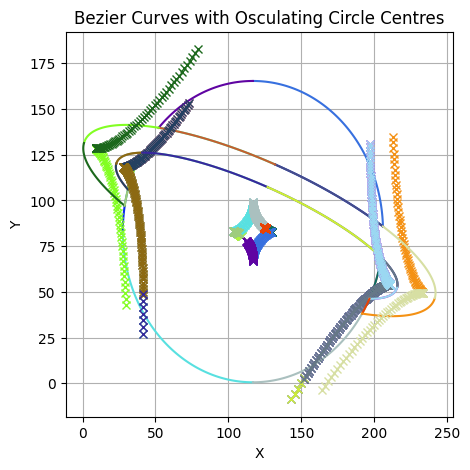

In [3]:
plot_bezier_curves(extract_bezier_curves(file_path)[0], extract_bezier_curves(file_path)[1], size = 5)
plot_bezier_curves(extract_bezier_curves(file_path)[0], extract_bezier_curves(file_path)[1], show_centres=True, threshold=100, size = 5)

### Mediating Close-by Point Clusters

We have used the DBSCAN algorithm that will find non-flush close-by points and set mediate them with their centroidal value.  

**Neigbourhood Definition**: $N_\epsilon(p) = \{q \in D \mid \text{dist}(p, q) \leq \epsilon\}$

**Core Point**: $|N_\epsilon(p)| \geq \text{MinPts}$


In [12]:
cubic_beziers = extract_bezier_curves(file_path)[0]
tolerance = 0.5

# Extract the start and end points
startpoints = cubic_beziers[:, 0, :]
endpoints = cubic_beziers[:, -1, :]

# Combine start and end points
all_points = np.vstack((startpoints, endpoints))

# Use DBSCAN to find clusters of close points
db = DBSCAN(eps=tolerance, min_samples=2).fit(all_points)

# Get the labels assigned by DBSCAN (-1 means noise, i.e., points that are not part of any cluster)
labels = db.labels_

# Update the points to the centroid of their clusters
for label in set(labels):
    if label != -1:
        indices = np.where(labels == label)[0]
        centroid = np.mean(all_points[indices], axis=0)
        all_points[indices] = centroid

# Update the original array with the new centroid values
cubic_beziers[:, 0, :] = all_points[:len(cubic_beziers)]
cubic_beziers[:, -1, :] = all_points[len(cubic_beziers):]

# len(cubic_beziers)

### Planarize the Bezier Plot

The Following simple algorithm that removes duplicate overlaps, while still maintaining plot integrity:

$\text{Given:} \, C = \{c_1, c_2, \dots, c_n\}, \text{ where each } c_i = \{p_{i1}, p_{i2}, \dots, p_{im}\} \text{ is a curve.} \\$
$\text{Initialize:} \, S = \emptyset, \quad E = \emptyset \\$
$\text{For each curve } c_i \in C: \\$
$\quad \text{Let } s_i = p_{i1}, \quad e_i = p_{im} \\$
$\quad \text{If } (s_i, e_i) \notin E \text{ and } (e_i, s_i) \notin E: \\$
$\quad \quad S = S \cup \{c_i\} \\$
$\quad \quad E = E \cup \{(s_i, e_i)\} \\$
$Return\ S$

In [13]:
def get_unique_curves(curves):
    """
    Returns a list of unique curves based on their start and end points.

    Parameters:
    curves (list of lists): A list where each element is a curve represented by a list of points.

    Returns:
    np.ndarray: An array of unique curves, ignoring curves that are identical when reversed.
    """
    unique_curves = []
    seen_endpoints = set()
    
    for curve in curves:
        start, end = tuple(curve[0]), tuple(curve[-1])
        if (start, end) not in seen_endpoints and (end, start) not in seen_endpoints:
            unique_curves.append(curve)
            seen_endpoints.add((start, end))
    
    return np.array(unique_curves)


cubic_beziers = get_unique_curves(cubic_beziers)
# print(len(cubic_beziers))

### Extract Corner Points

To extract the tangent vectors from a Bézier curve, you need to compute the derivative of the Bézier curve's equation. For a Bézier curve of degree \( n \), the curve is defined as:

$
\mathbf{B}(t) = \sum_{i=0}^{n} \mathbf{P}_i \, B_{i,n}(t)
$

where:
- $\mathbf{P}_i$ are the control points,
- $B_{i,n}(t)$ are the Bernstein polynomials defined as:
  $
  B_{i,n}(t) = \binom{n}{i} t^i (1-t)^{n-i}
  $

The tangent vector at a point on the curve is given by the derivative of the curve with respect to the parameter $t$:

$
\mathbf{B}'(t) = \frac{d}{dt} \mathbf{B}(t)
$

To compute this derivative, differentiate the Bézier curve equation:

$
\mathbf{B}'(t) = \sum_{i=0}^{n} \mathbf{P}_i \, \frac{d}{dt} B_{i,n}(t)
$

The derivative of the Bernstein polynomial \( B_{i,n}(t) \) is:

$
\frac{d}{dt} B_{i,n}(t) = n \left[ B_{i-1,n-1}(t) - B_{i,n-1}(t) \right]
$

Thus, the derivative of the Bézier curve becomes:

$
\mathbf{B}'(t) = n \sum_{i=0}^{n-1} \left( \mathbf{P}_{i+1} - \mathbf{P}_i \right) B_{i,n-1}(t)
$

This expression gives the tangent vector $\mathbf{B}'(t)$ at any point $t$ on the Bézier curve. The tangent vector is a linear combination of the differences between consecutive control points, weighted by the Bernstein polynomials of degree $n-1$.

Then a simple repeating element removing algorithm successfully obtains all the corner points and theire respective non-transitioning tangents.   
The documentation will provide more insights to our code.



In [14]:
def bezier_tangent_equations(P0, P1, P2, P3):
    """
    Calculate the tangents (slopes) at the start and end points of a cubic Bézier curve.
    
    Parameters:
        P0, P1, P2, P3 (array-like): Control points of the cubic Bézier curve.
        
    Returns:
        tuple: Slopes at the start and end points of the curve.
    """
    # Derivatives at t = 0 and t = 1
    derivative_start = 3 * (P1 - P0)
    derivative_end = 3 * (P3 - P2)
    
    # Slopes at the endpoints
    slope_start = derivative_start[1] / derivative_start[0] if derivative_start[0] != 0 else np.inf
    slope_end = derivative_end[1] / derivative_end[0] if derivative_end[0] != 0 else np.inf
    
    return slope_start, slope_end

# Dictionary to store slopes for each start and end point of the Bézier curves
slope_dict = {}
for cubic_bezier in cubic_beziers:
    start_point = cubic_bezier[0]
    end_point = cubic_bezier[-1]
    slope_dict[tuple(np.round(start_point, decimals=4))] = []
    slope_dict[tuple(np.round(end_point, decimals=4))] = []

for cubic_bezier in cubic_beziers:
    start_point = cubic_bezier[0]
    end_point = cubic_bezier[-1]
    slope_start, slope_end = bezier_tangent_equations(cubic_bezier[0], cubic_bezier[1], cubic_bezier[2], cubic_bezier[3])
    slope_dict[tuple(np.round(start_point, decimals=4))].append(slope_start)
    slope_dict[tuple(np.round(end_point, decimals=4))].append(slope_end)

def almost_equal(a, b, threshold):
    """
    Check if two slopes are almost equal within a given angular threshold.
    
    Parameters:
        a, b (float): Slopes to compare.
        threshold (float): Angle in degrees within which the slopes are considered equal.
        
    Returns:
        bool: True if slopes are almost equal, False otherwise.
    """
    a_rad = math.atan(a)
    b_rad = math.atan(b)
    return abs(a_rad - b_rad) <= math.radians(threshold)

def remove_almost_equal_elements(lst, epsilon=0.1):
    """
    Remove slopes from a list that are almost equal within a specified epsilon.
    
    Parameters:
        lst (list): List of slopes.
        epsilon (float): Tolerance threshold for considering slopes as equal.
        
    Returns:
        list: List with almost equal slopes removed.
    """
    n = len(lst)
    maparray = [False] * n
    for i in range(n):
        for j in range(i + 1, n):
            if almost_equal(lst[i], lst[j], 5):
                maparray[i] = True
                maparray[j] = True
    return [lst[i] for i in range(n) if not maparray[i]]

# Remove almost equal slopes from the slope dictionary
for point in slope_dict:
    slope_dict[point] = remove_almost_equal_elements(slope_dict[point], 0.1)

corner_points = {}
for point in slope_dict:
    if len(slope_dict[point]) == 1:
        corner_points[point] = slope_dict[point][0]
# corner_points


### Point Pairing Logic

The point pairing is also related to the Osculating Circle centre logic, to evaluate if a smooth cubic bezier can **naturally** smoothen out the gap with infilling.

#### 1. Pair Generation
Given a set of points $p_1, p_2, \dots, p_n$ and their corresponding slopes $s_1, s_2, \dots, s_n$, the code generates all possible unique pairs.
 Mathematically, these pairs are the combinations:

$
\text{Pairs} = \left\{(p_i, p_j) \mid 1 \leq i < j \leq n \right\}
$

#### 2. Filter Pairs on the Same Bézier Curve
For each pair \((p_i, p_j)\), we check if both points lie on the same Bézier curve. Let $B_k(t)$ represent the $k$-th Bézier curve parameterized by $t$. The condition can be expressed as:

$
\exists k \text{ such that } p_i \in B_k \text{ and } p_j \in B_k
$

If this condition holds, the pair \((p_i, p_j)\) is discarded.

#### 3. Calculate Angle Between Slopes
For each valid pair $(p_i, p_j)$ with corresponding slopes $s_i$ and $s_j$, compute the angle $\theta_{ij}$ between the slopes using the formula:

$
\theta_{ij} = \arctan\left(\frac{|s_j - s_i|}{1 + s_i s_j}\right)
$

This formula derives from the tangent of the angle between two lines with slopes $s_i$ and $s_j$.

#### 4. Calculate Distance Between Points
Compute the Euclidean distance $d_{ij}$ between the points $p_i$ and $p_j$:

$
d_{ij} = \sqrt{(x_j - x_i)^2 + (y_j - y_i)^2}
$

where $p_i = (x_i, y_i)$ and $p_j = (x_j, y_j)$.

#### 5. Sort Pairs
Sort all valid pairs $(p_i, p_j)$ based on the distance $d_{ij}$ and angle $\theta_{ij}$. The sorting criteria can be expressed as:

$
\text{Sort by } (d_{ij}, \theta_{ij})
$

This means pairs with smaller distances are prioritized, and among those with equal distances, smaller angles are favored.

#### 6. Select Optimal Pairs
Starting from the sorted list, select pairs $(p_i, p_j)$ such that each point $p_i$ or $p_j$ is only used once. This can be mathematically represented as:

$
\text{Select } (p_i, p_j) \text{ such that } p_i \notin \{p_1, \dots, p_{i-1}, p_{j-1}\} \text{ and } p_j \notin \{p_1, \dots, p_{i-1}, p_{j-1}\}
$

This selection continues until four distinct pairs are chosen.

#### 7. Output
The final output consists of four pairs $(p_{i_1}, p_{j_1}), (p_{i_2}, p_{j_2}), (p_{i_3}, p_{j_3}), (p_{i_4}, p_{j_4})$ that satisfy the criteria of minimum distance, minimal angle difference, and uniqueness of points.


In [15]:
# Bezier curve endpoints
bezier_curves = np.round(cubic_beziers, decimals=3)
# Function to check if two points are on the same bezier curve
def on_same_bezier_curve(p1, p2, haha):
    for curve in haha:
        if any(np.all(curve == p1, axis=1)) and any(np.all(curve == p2, axis=1)):
            return True
    return False

# Calculate angle between two slopes
def angle_between_slopes(slope1, slope2):
    angle = math.atan(abs((slope2 - slope1) / (1 + slope1 * slope2)))
    return math.degrees(angle)

# Calculate distance between two points
def distance_between_points(p1, p2):
    return math.sqrt((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2)

# Analyze pairs
pairs = []
for (p1, s1), (p2, s2) in combinations(corner_points.items(), 2):
    if not on_same_bezier_curve(p1, p2, bezier_curves):
        angle = angle_between_slopes(s1, s2)
        distance = distance_between_points(p1, p2)
        pairs.append((p1, p2, angle, distance))

# Sort pairs based on predefined criteria: distance and angle
sorted_pairs = sorted(pairs, key=lambda x: (x[3], x[2]))

# Get the required pairs
result_pairs = []
for pair in sorted_pairs:
    p1, p2 = pair[0], pair[1]
    if (p1 not in [p for pair in result_pairs for p in pair]) and (p2 not in [p for pair in result_pairs for p in pair]):
        result_pairs.append((p1, p2))
        if len(result_pairs) == 4:
            break

# Output the results
# for pair in result_pairs:
#     print(f"Pair: {pair}")

### Final Output

After pairing up the points, we use a simple technique to obtain the infilling bezir curve's control points.

1. **Intersection of Lines:**

$
\text{If } m_1 \neq m_2, \quad \left(x_{\text{intersect}}, y_{\text{intersect}}\right) = \left(\frac{m_1 x_1 - m_2 x_2 + y_2 - y_1}{m_1 - m_2}, \, m_1 \left(\frac{m_1 x_1 - m_2 x_2 + y_2 - y_1}{m_1 - m_2} - x_1\right) + y_1\right)
$

2. **Bézier Curve Control Points:**

$
\text{Control Points} = \left[(x_1, y_1), \left(\frac{x_1 + x_{\text{int}}}{2}, \frac{y_1 + y_{\text{int}}}{2}\right), \left(\frac{x_2 + x_{\text{int}}}{2}, \frac{y_2 + y_{\text{int}}}{2}\right), (x_2, y_2)\right]
$



In [16]:
def find_intersection(x1, y1, m1, x2, y2, m2):
    """
    Finds the intersection of two lines.
    Raises ValueError if lines are parallel.
    """
    if m1 == m2:
        raise ValueError("Lines are parallel.")
    x_intersect = (m1 * x1 - m2 * x2 + y2 - y1) / (m1 - m2)
    y_intersect = m1 * (x_intersect - x1) + y1
    return x_intersect, y_intersect

def make_filler_curve(x1, y1, m1, x2, y2, m2):
    """
    Creates a Bézier curve connecting two lines.
    """
    x_int, y_int = find_intersection(x1, y1, m1, x2, y2, m2)
    cx1, cy1 = (x1 + x_int) / 2, (y1 + y_int) / 2
    cx2, cy2 = (x2 + x_int) / 2, (y2 + y_int) / 2
    return [(x1, y1), (cx1, cy1), (cx2, cy2), (x2, y2)]

# Generate Bézier curves and plot them
control_points = [make_filler_curve(p1[0], p1[1], corner_points[p1], p2[0], p2[1], corner_points[p2])
                  for p1, p2 in result_pairs]
final_curves = np.vstack((cubic_beziers, np.array(control_points)))


# OUTPUT

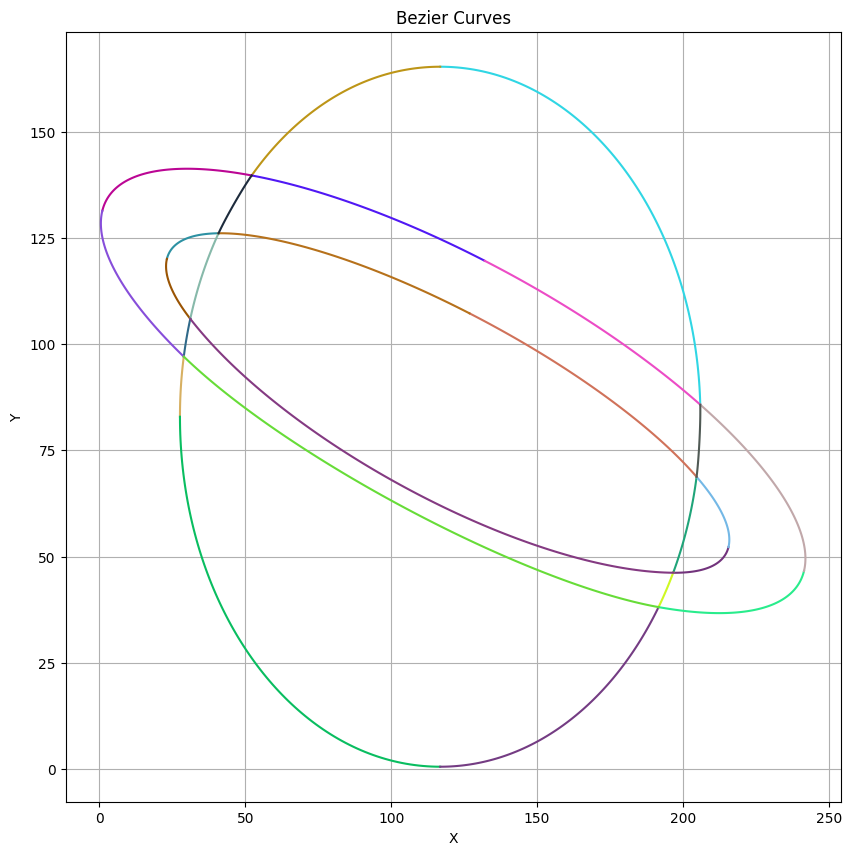

In [9]:
plot_bezier_curves(final_curves, [])

# OUTPUT

For the second testcase:

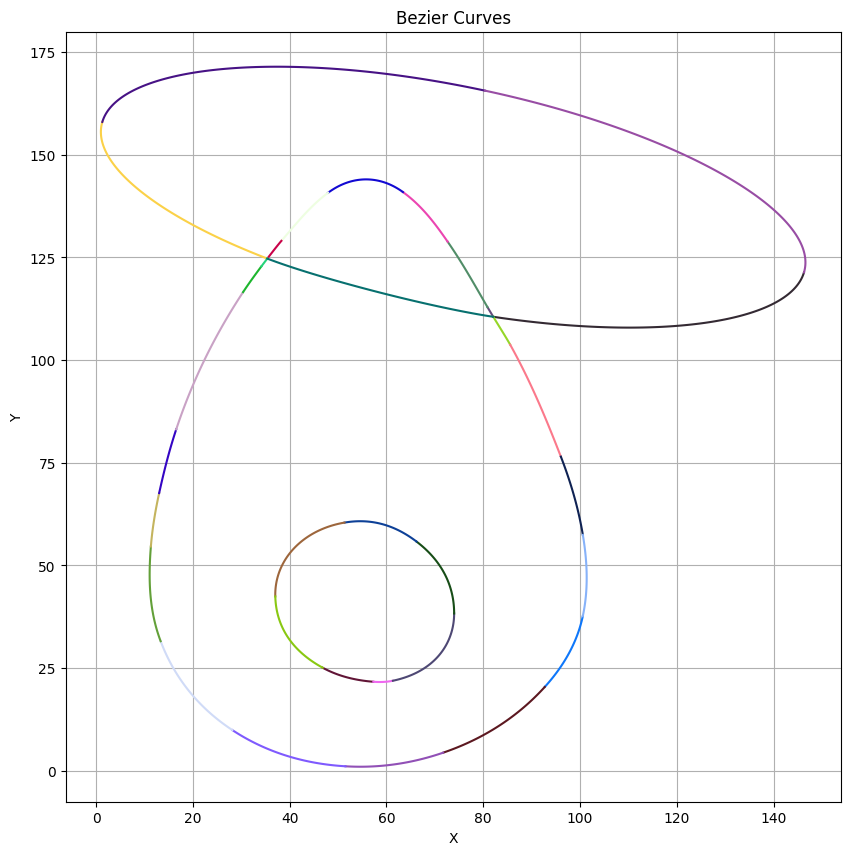

In [17]:
#RUN FROM CELL NUMBER 4, WITH NEW FILEPATH
file_path = 'data/problems/occlusion1.svg'
plot_bezier_curves(final_curves, [])